## Plot temperatures, other fields

* After much pain with contour labels, I discovered it is importnant to add the label after the axes configuration - i.e. limits, aspect ratio. etc

In [1]:
velScale = 3.4482758620689656e-13*(3600*24*365)*100.  #cm/y
timeScale = 8.41e+18/(1e6*3600*24*365)    
tempScale = 1400.0
stressScale = 11.890606
adiabatTempGrad = 0.8253168000

In [2]:
#%pylab inline

import matplotlib.pyplot as plt
import numpy as np

#import seaborn as sns
import glob2
import pandas as pd
import h5py
from scipy.ndimage.filters import gaussian_filter
import natsort
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from matplotlib.colors import LogNorm


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import matplotlib.patches as patches
#import matplotlib.gridspec as gridspec
#from matplotlib.colors import LogNorm
#from matplotlib import  ticker

In [4]:
plotting = True
if plotting is False:
    plt.ioff()
else:
    %pylab inline

    

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [5]:
def get_dataframe(M, N):
    file_ = '../models/results/{}/{}/values/tect_model_data.npz'.format(M, N)
    #file_ = '../models/results/A/{}/values/tect_model_data.npz'.format(num)
    out = np.load(file_)
    d = dict(out)
    df = pd.DataFrame.from_dict(d)
    return df 

In [6]:
#ls ../models/results/B/16/values/

In [7]:
def get_along_strike(pts):
    dxs = np.diff(pts[:,0])
    dys = np.diff(pts[:,1])
    ds = np.sqrt(dxs**2 + dys**2)
    
    #pad the first point
    return np.append(ds[0], ds) , np.cumsum(np.append([0.], ds)) #front and back pad these arrays

In [8]:
def listify_data(unique_string, path):
    glob_str = path + '*' + unique_string + '*'
    files = natsort.natsort(glob2.glob(glob_str))
    #print(glob_str)
    #return files
    
    dataList = []
    for f in files:
        with h5py.File(f,'r') as hf:
            data = hf.get('data')
            dataList.append(np.array(data))
    return dataList

In [9]:
def mddFn(depths, yvels):
    for i in range(len(depths)):
        mask = depths[i] > 50
        ref = (-1.*yvels[i][mask]).max()/2.5
        index = np.argmin(np.abs((-1.*yvels[i][mask]) - ref))
        mddF = depths[i][mask][index]
        yield mddF/2900.

In [10]:
def prune_recursive(data, n, tol = 0.1, safe = 5):
    """
    We want to avoid points where the slab is inverted.
    We recursively eliminate points from the deepest

    """
    
    
    #assume data is not depth odrered
    
    ysorted = data[np.argsort(data[:,1])]
    xsortedData = ysorted[np.argsort(ysorted[:,0])]
    
    ds = abs(np.mean(np.diff(xsortedData[:,0][10:110])))
    
    mask = 0

    while np.abs(np.max(np.diff(xsortedData[:,1]))) > ds*tol:
        mask += n
        ysorted = data[np.argsort(data[:,1])][mask:]
        xsortedData = ysorted[np.argsort(ysorted[:,0])]
    
    ysorted = data[np.argsort(data[:,1])][mask + safe:]
    xsortedData = ysorted[np.argsort(ysorted[:,0])]
    return xsortedData 

In [11]:
def wrap_invert_spline(result, trench, maxIntData):
    mask = np.logical_and(result > trench, result < maxIntData)
    if mask.sum() > 0.:
        result = result[mask]
    if len(result) == 1:
        return result[0]
    else:
        return result[1]

In [12]:
def prune_recursive(data, n, tol = 0.1, safe = 5):
    """
    We want to avoid points where the slab is inverted.
    We recursively eliminate points from the deepest

    """
    
    
    #assume data is not depth odrered
    
    ysorted = data[np.argsort(data[:,1])]
    xsortedData = ysorted[np.argsort(ysorted[:,0])]
    
    ds = abs(np.mean(np.diff(xsortedData[:,0][10:110])))
    
    mask = 0

    while np.abs(np.max(np.diff(xsortedData[:,1]))) > ds*tol:
        mask += n
        ysorted = data[np.argsort(data[:,1])][mask:]
        xsortedData = ysorted[np.argsort(ysorted[:,0])]
    
    ysorted = data[np.argsort(data[:,1])][mask + safe:]
    xsortedData = ysorted[np.argsort(ysorted[:,0])]
    return xsortedData 

## Get flat slab data

#Needed
dfC32
meshData4
visc
temp

visc[viscindexes]
shiftData

trench

In [13]:
dfB16 = get_dataframe('B', '16')


In [87]:
timeToPlot = 20.

#Shallow
ixB16 = np.argmin(np.abs(dfB16.timeAtSave*timeScale - timeToPlot))


In [88]:
#Mesh
hf = h5py.File('/workspace2/flat_slab/B/16/mesh.h5', 'r')
meshData = np.array(hf.get("vertices"))


tempFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/{}/{}/**temp**h5'.format('B', '16')))
ixB16 = np.argmin(np.abs(dfB16.timeAtSave*timeScale - timeToPlot))
hf = h5py.File(tempFiles[ixB16], 'r')
temp = np.array(hf.get("data"))[:,0]
temp += adiabatTempGrad*( 1. - meshData[:,1])
temp *=tempScale


viscFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/{}/{}/**visc**h5'.format('B', '16')))
hf = h5py.File(viscFiles[ixB16], 'r')
visc = np.array(hf.get("data"))[:,0]
visc = visc.copy()*1e20


In [89]:
hf = h5py.File('./analysis_data/mesh.h5', 'r')
meshData = np.array(hf.get("vertices"))


In [90]:
hf = h5py.File('./analysis_data/temp_2200.h5', 'r')
tempData = np.array(hf.get("data"))

In [91]:
pointsList = listify_data('interface', '../models/results/{}/{}/**/'.format('B', '16'))
points = pointsList[ixB16 + 1]

indexes =  np.argsort(points[:,0])
sortedData = points[indexes]

sortedData  = prune_recursive(sortedData, 5, tol = 0.7,safe=20)
xlim = sortedData[:,0][np.argmin(np.abs((1. - sortedData[:,1])*2900 - 25.) )] - (400./2900)
startindex = np.argmin(np.abs(sortedData[:,0] - xlim))
sortedData = sortedData[startindex:,:]

fy = CubicSpline(sortedData[:,0], sortedData[:,1])
y1_ = fy.derivative(1)(sortedData[:,0])
y2_ = fy.derivative(2)(sortedData[:,0])
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)
normals_rad = np.arctan(y1_) + np.pi/2

scalar0 = 7.5/2900.
shiftData = np.column_stack((sortedData[:,0] + np.cos(normals_rad)*scalar0, 
                             sortedData[:,1] + np.sin(normals_rad)*scalar0 ))

scalar2 = 10./2900.
shiftData2 = np.column_stack((sortedData[:,0] + np.cos(normals_rad)*scalar2, 
                             sortedData[:,1] + np.sin(normals_rad)*scalar2 ))

indexes2 =  np.argsort(shiftData[:,0])
shiftData = shiftData[indexes2]

ds, ds_cum = get_along_strike(sortedData)
dsMean = ds.mean()

In [92]:
#Get data along vertical transect

trench = dfB16['(2, 3)'][ixB16]*2900. - 40
trench_ = dfB16['(2, 3)'][ixB16]

pointForVisc = -1730./2900 #ridge loc
#-0.6

viscindexes = np.isclose(meshData[:,0], 0.)
get2 = meshData[np.argmin( np.abs(meshData[:,0] - pointForVisc) ),0]

viscindexes = np.isclose(meshData[:,0], get2 ) 

In [93]:
#-1740.

In [94]:
maskThis = 2900.*shiftData2[:,0] > trench + 150.
dimIntData = np.column_stack((2900.*shiftData2[maskThis,0], 
                           2900.*(1. - shiftData2[maskThis,1])))


indexWedge = np.argmin(np.abs(shiftData2[maskThis,1] - 45)) #this determines where the LVW intersects the subduction interface


## Do the fig

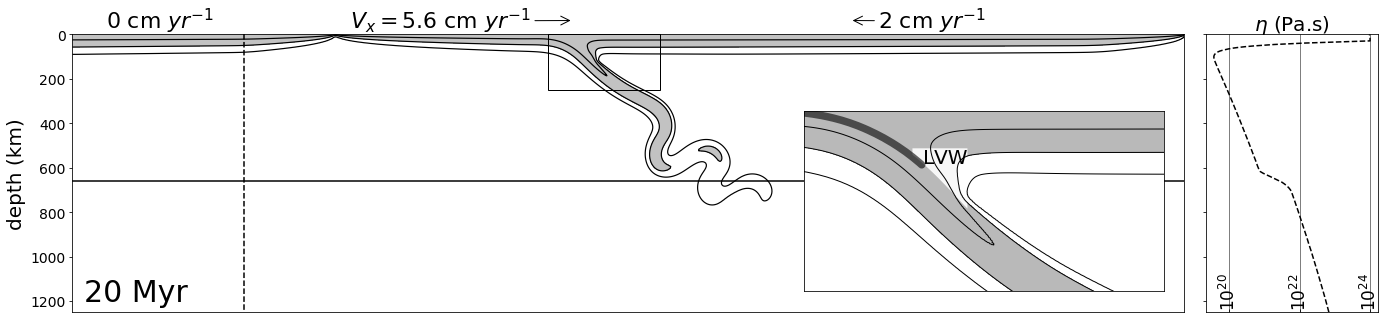

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex='col', sharey=True,
                               gridspec_kw={'width_ratios': [8, 1]},
                               figsize=(20, 4.2))

fig.set_tight_layout({'rect': [0, 0, 1, 1], 'pad': 0.0, 'h_pad': 0.1})

ax = axes[0]




viscLevs =  np.array([0.5, 2.0,  1e5])*1e20
#viscLevs =  np.array([0.1, 0.4, 10, 50, 200, 1000, 2500, 1e5])*1e20

#cb1 = ax.tricontourf((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  
#                visc[:], 
#                cmap='Greys',
#                levels = viscLevs,
#                vmin = 1e20*1e1, vmax = 1e20*9e3,
#                    norm = LogNorm(), alpha = 0.2)

cb1 = ax.tricontourf((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  
                    temp,
                    vmax = 1350, vmin = 0,
                     cmap='Greys', alpha=0.7,#

                     levels =  [0.,  1200.])



con1 = ax.tricontour((2900*meshData[:,0] ), 2900*(1. - meshData[:,1]),  

                    temp,
                    vmin =0, vmax = 1350, alpha=1., 
                    levels = [650, 1200, 1400], colors= 'k', linewidths = 1.2 )



    
#for i in [27]:
#    ixB16_ = np.argmin(np.abs(dfB16.timeAtSave*timeScale - i))
#    hf = h5py.File(tempFiles[ixB16_], 'r')
#    tempB16 = np.array(hf.get("data"))[:,0]
#    tempB16 += adiabatTempGrad*( 1. - meshData[:,1])
#    tempB16 *=tempScale
#    
#    con = ax.tricontour((2900*meshData[:,0] ), 2900*(1. - meshData[:,1]),  

#                    tempB16,
#                    vmin =0, vmax = 1350, alpha=0., 
#                    levels = [1100, 1400], colors= 'k', linewidths = 0.0 )
    
    
#    p = con.collections[0].get_paths()
#    pv = [path.vertices for path in p]
#    Iso1 = np.concatenate(pv) #already dimensionalized
        
#    #mask = np.logical_and(Iso1[:,0] < trench, Iso1[:,1] > 100)
#    #mask = Iso1[:,1] > 90
#    mask =  Iso1[:,0] < trench + 1500.
#    ax.plot(Iso1[mask,0], Iso1[mask,1], c= 'k', lw = 0.5, ls = '-' )
    


ax.set_ylabel('depth (km)', fontsize= 20)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlim(-2500, 2500 )
ax.set_ylim(1250, 0)
ax.set_aspect(1)

#cl = ax.clabel(con2, fontsize=15, inline=1, fmt='%1.0f' + r'$^{\circ}$C', 
#           manual=[(trench + 380, 50),(trench + 380, 75)], inline_spacing=6)

ax.vlines(pointForVisc*2900., 0, 1250, linestyles='--', colors='k')
ax.hlines(660., -2500, 2500,  linestyles='-', colors='k')


##########################################
#ax2
##########################################

ax2 = axes[1]

ax2.plot( visc[viscindexes], (1. - meshData[viscindexes,1])*2900., c ='k', ls ='--' )
ax2.set_xscale('log')
ax2.set_xticks([1e20,  1e22, 1e24])

ax2.tick_params(axis="x",direction="in", pad=-40)
ax2.xaxis.set_tick_params(labelsize=17)
ax2.set_xlabel(r'$\eta$ (Pa.s)', fontsize= 20)
#ax2.tick_params(labelbottom='off',labeltop='on')
ax2.xaxis.set_label_position('top')

ax2.vlines(1e20, 0, 1250, linestyles='-', colors='k', lw = 0.5)
ax2.vlines(1e22, 0, 1250, linestyles='-', colors='k', lw = 0.5)
ax2.vlines(1e24, 0, 1250, linestyles='-', colors='k', lw = 0.5)


for tick in ax2.get_xticklabels():
        tick.set_rotation(90)
        
        
##########################################
#Inset
##########################################

in_ax = fig.add_axes([0.6, 0.08, 0.25, 0.6]) 

if timeToPlot < 20.0:
    depthmask = (1.0 - shiftData[::1,1])*2900. < 100.
else:
    depthmask = (1.0 - shiftData[::1,1])*2900. < 75.

ln, = in_ax.plot(2900.*(shiftData[depthmask,0]), 
           gaussian_filter((1.0 - shiftData[depthmask,1])*2900., 0), lw = 7.5, 
                 ls = '-', c = 'k', alpha = 0.6, zorder=1e3, label='sub. interface' )

ln.set_solid_capstyle('round')


in_ax.set_xlim(trench, 500 + trench)
in_ax.set_ylim(250, 0)
in_ax.set_aspect(1)
in_ax.get_xaxis().set_visible(False)
in_ax.get_yaxis().set_visible(False)

if timeToPlot == 27.0:
    
    in_ax.annotate('LVW', xy=(0.8, 0.71), xycoords='axes fraction',  fontsize=20)
    #t0.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

if timeToPlot == 20.0:
    in_ax.annotate('LVW', xy=(0.33, 0.71), xycoords='axes fraction',  fontsize=20)    
    #t0.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

ax.get_xaxis().set_visible(False)


#cb1 = in_ax.tricontourf((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  
#               visc[:], 
#                cmap='Greys',
#                levels = viscLevs,
#                vmin = 1e20*1e1, vmax = 1e20*9e3,
#                    norm = LogNorm(), alpha = 0.3)


cb2 = in_ax.tricontourf((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  
                    temp,
                    vmax = 1350, vmin = 0,
                     cmap='Greys', alpha=0.8,#

                     levels =  [0.,  1200.])



con2 = in_ax.tricontour((2900*meshData[:,0] ), 2900*(1. - meshData[:,1]),  

                    temp,
                    vmin =0, vmax = 1350, alpha=1., 
                    levels = [650, 1200, 1400], colors= 'k', linewidths = 1 )


if timeToPlot >= 20.0:
    in_ax.fill_between(dimIntData[indexWedge:,0] , 
                 dimIntData[indexWedge:,1], 52*np.ones(len(dimIntData[indexWedge:,1])), 
                 facecolor='white', alpha=0.9) 

if timeToPlot == 0.0:
    in_ax.legend(loc = 4, fontsize = 16)

# Create a Rectangle patch
rect = patches.Rectangle((trench,0),500,250,linewidth=1,edgecolor='k',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)


#ax.arrow(0, 0, 500, 500, head_width=0.05, head_length=0.1, fc='k', ec='k')

vSP = np.round( (9 - 3)*(1. - timeToPlot/35.) + 3, 1)

ax.annotate(r'0 cm $yr^{-1}$', xy=(0.03, 1.02), xycoords='axes fraction',  fontsize=22)


ax.annotate(r'$V_x = {}$'.format(vSP) +  r' cm $yr^{-1}$', xy=(0.45, 1.05), xycoords='axes fraction', xytext=(0.25, 1.02), fontsize=22,
            arrowprops=dict(arrowstyle="->", color='k'))
            
ax.annotate(r'2 cm $yr^{-1}$', xy=(0.7, 1.05), xycoords='axes fraction', xytext=(0.725, 1.02), fontsize=22,
            arrowprops=dict(arrowstyle="->", color='k'))

#Label boundary condiutions
if timeToPlot == 0.0:
    
    ax.annotate('y', xy=(0.17, 0.05), xycoords='axes fraction', xytext=(0.165, 0.3), fontsize=20,
            arrowprops=dict(arrowstyle="<-", color='k'))
    
    ax.annotate('x', xy=(0.168, 0.051), xycoords='axes fraction', xytext=(0.235, 0.035), fontsize=20,
            arrowprops=dict(arrowstyle="<-", color='k'))
    
    ax.text(-1150, 1200, r'$V_y = 0.$' , fontsize=22)
    ax.text(-750, 1200, r'$\frac{\partial{T}}{\partial{y}} = 0.$' , fontsize=24)
    
    ax.text(-1250, 150, r'$V_y = 0.$' , fontsize=24)
    ax.text(-850, 150, r'$T = 273$ K' , fontsize=24)
    
    ax.text(-2490, 350, r'$V_x = 0.$' , fontsize=22, rotation=-90)
    ax.text(-2490, 780, r'$\frac{\partial{T}}{\partial{x}} = 0.$' , fontsize=24, rotation=-90)
    
    ax.text(2400, 350, r'$V_x = 0.$' , fontsize=22, rotation=90)
    ax.text(2400, 780, '1673 K' , fontsize=22, rotation=90)
    
    t = ax.text(pointForVisc*2900. + 150, 680, r'$\times\eta_{660}  = 5.0$', fontsize=22)
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

    


#ax.annotate(r' <- + 500 km', xy=(0.05, 0.05), xycoords='axes fraction', fontsize=25, color='k')

ax.text(-2450, 1200, '{} Myr'.format(int(timeToPlot)), fontsize=30)




fig.tight_layout()


In [96]:
timeToPlot

20.0

In [97]:
#vSP = np.round( (9 - 3)*(1. - 0/35.) + 3, 1)

In [99]:
#fig.savefig('model_setup_{}'.format(int(timeToPlot)), dpi=300, bbox_inches='tight')

In [71]:
pointsList = listify_data('interface', '../models/results/{}/{}/**/'.format('B', '16'))
points = pointsList[ixB16 + 1]

indexes =  np.argsort(points[:,0])
sortedData = points[indexes]

sortedData  = prune_recursive(sortedData, 5, tol = 0.7,safe=20)
xlim = sortedData[:,0][np.argmin(np.abs((1. - sortedData[:,1])*2900 - 25.) )] - (400./2900)
startindex = np.argmin(np.abs(sortedData[:,0] - xlim))
sortedData = sortedData[startindex:,:]

fy = CubicSpline(sortedData[:,0], sortedData[:,1])
y1_ = fy.derivative(1)(sortedData[:,0])
y2_ = fy.derivative(2)(sortedData[:,0])
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)
normals_rad = np.arctan(y1_) + np.pi/2

scalar = 5./2900.
shiftData = np.column_stack((sortedData[:,0] + np.cos(normals_rad)*scalar, 
                             sortedData[:,1] + np.sin(normals_rad)*scalar ))


indexes2 =  np.argsort(shiftData[:,0])
shiftData = shiftData[indexes2]

ds, ds_cum = get_along_strike(sortedData)
dsMean = ds.mean()

In [72]:
## Scratch

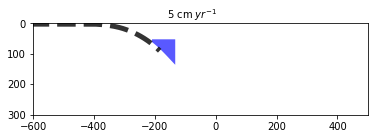

In [73]:
fig, ax = plt.subplots()


##########################################
#trench = dfC32['(1, 2)'][ixC32]*2900. - 40


viscLevs =  np.array([0.5, 4.0,  1e5])*1e20



#cb1 = ax.tricontourf((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  
#                visc[:], 
#                cmap='Greys',
#                levels = viscLevs,
#                vmin = 1e20*1e1, vmax = 1e20*9e3,
#                    norm = LogNorm(), alpha = 0.3)


ax.fill_between(dimIntData[indexWedge:,0] , 
                 dimIntData[indexWedge:,1], 52*np.ones(len(dimIntData[indexWedge:,1])), 
                 facecolor='blue', alpha=0.65) 

#ax.annotate(r'5 cm $yr^{-1}$', xy=(0.4, 1.05), xycoords='axes fraction', xytext=(0.0, 1.02), 
#            arrowprops=dict(arrowstyle="->", color='k'))

ax.annotate(r'5 cm $yr^{-1}$', xy=(0.4, 1.05), xycoords='axes fraction')

ax.set_xlim(-600, 500)
ax.set_ylim(300, 0)
ax.set_aspect('equal')


depthmask = (1.0 - shiftData[::1,1])*2900. < 90
ln, = ax.plot(2900.*(shiftData[depthmask,0]), 
           gaussian_filter((1.0 - shiftData[depthmask,1])*2900., 0), lw = 5, ls = '--', c = 'k', alpha = 0.8)

ln.set_solid_capstyle('round')

#cl = ax.clabel(cb_, fontsize=15, inline=1, fmt='%1.0f' + r'$^{\circ}$C', 
#           manual=[(trench + 380, 50),(trench + 380, 75)], inline_spacing=6)

In [60]:
meshData[:,0].min()*2900., meshData[:,0].max()*2900. 

(-2499.9999999983193, 2499.9999999983193)

In [61]:
for i in [27]:
    ixB16 = np.argmin(np.abs(dfB16.timeAtSave*timeScale - i))
    hf = h5py.File(B16Files[ixB16], 'r')
    tempB16 = np.array(hf.get("data"))[:,0]
    tempB16 += adiabatTempGrad*( 1. - meshData[:,1])
    tempB16 *=tempScale
    
    con = ax.tricontour((2900*meshData[:,0] ), 2900*(1. - meshData[:,1]),  

                    tempB16,
                    vmin =0, vmax = 1350, alpha=0., 
                    levels = [1400], colors= 'k', linewidths = 0.0 )
    
    
    p = con.collections[0].get_paths()
    pv = [path.vertices for path in p]
    Iso1 = np.concatenate(pv) #already dimensionalized
        
    #mask = np.logical_and(Iso1[:,0] < trench, Iso1[:,1] > 100)
    #mask = Iso1[:,1] > 90
    ax.plot(Iso1[:,0], Iso1[:,1], c= 'k', lw = 0.5, ls = '-' )

NameError: name 'B16Files' is not defined

In [383]:
ax.annotate?